<a href="https://colab.research.google.com/github/Takato0884/DS_Competition_NLP/blob/main/TextFeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# クラス定義

In [1]:
# colaboratoryの約束事

from google.colab import drive, files
import os
 
drive.mount('/content/drive')  # drive をマウント
COLAB = "/content/drive/MyDrive/CommonLit"  # colaboratory の path (必要時応じて変更)
os.chdir(COLAB)
!pip install transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
nltk.download('punkt')
import transformers
import random
import warnings
warnings.simplefilter('ignore')
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
class TextFeatureExtraction:
  def __init__(self, text_df, top_percent, bottom_percent, num_of_limit_word_list):
    # 変数定義
    text_df = text_df
    text_df["excerpt_prepro"] = 0
    top_index = round(len(text_df) * top_percent)
    bottom_index = round(len(text_df) * bottom_percent)
    word_top = []
    word_bottom = []
    word_top_count = []
    word_bottom_count = []
    self.word_top_remove_dup = []
    self.word_top_remove_dup_count = []
    self.word_bottom_remove_dup = []
    self.word_bottom_remove_dup_count = []
    self.top_word_and_count_list = []

    # 前処理
    for i in range(len(text_df)):
      replaced_text = text_df["excerpt"][i].lower()   # 小文字に変換
      replaced_text = re.sub(r'\d+', '0', replaced_text)    # 数字をすべて0に置き換え
      devided_text = replaced_text.splitlines() # \nの除去
      replaced_text = ' '.join(devided_text) # \nの除去
      replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
      text_df["excerpt_prepro"][i] = replaced_text
    
    # トークン化
    text_df['tokenized_sents'] = text_df.apply(lambda row: nltk.word_tokenize(row['excerpt_prepro']), axis=1)

    # 変数定義2
    text_df_sort = text_df.sort_values("target")
    text_df_top = text_df_sort[0:top_index]
    text_df_bottom = text_df_sort[len(df_train)-bottom_index: len(df_train)]
    text_df_top = text_df_top.reset_index()
    text_df_bottom = text_df_bottom.reset_index()

    # 上位n%の単語リストを作成
    words = {}
    for i in range(len(text_df_top)):
      for word in text_df_top['tokenized_sents'][i]:
        # 単語をキーとして値に1を足していく。
        # 辞書に単語がない、すなわち初めて辞書に登録するときは0+1になる。
        words[word] = words.get(word, 0) + 1

    d = [(v, k) for k, v in words.items()]
    d.sort()
    d.reverse()

    for count, word in d[:num_of_limit_word_list]:
        word_top.append(word)
        word_top_count.append(count)

    # 下位n%の単語リストを作成
    words = {}
    for i in range(len(text_df_bottom)):
      for word in text_df_bottom['tokenized_sents'][i]:
        # 単語をキーとして値に1を足していく。
        # 辞書に単語がない、すなわち初めて辞書に登録するときは0+1になる。
        words[word] = words.get(word, 0) + 1

    d = [(v, k) for k, v in words.items()]
    d.sort()
    d.reverse()

    for count, word in d[:num_of_limit_word_list]:
        word_bottom.append(word)
        word_bottom_count.append(count)

    # 上位n%と下位n%の頻出単語リストから重複単語を削除
    dup_top_worst = set(word_top) & set(word_bottom)
    dup_top_worst_list = list(dup_top_worst)
    # self.word_top = [i for i in self.word_top if i not in dup_top_worst_list]
    # self.word_bottom = [i for i in self.word_bottom if i not in dup_top_worst_list]
    for i in range(len(word_top)):
      if word_top[i] not in dup_top_worst_list:
        self.word_top_remove_dup_count.append(word_top_count[i])
        self.word_top_remove_dup.append(word_top[i])
    for i in range(len(word_bottom)):
      if word_bottom[i] not in dup_top_worst_list:
        self.word_bottom_remove_dup_count.append(word_bottom_count[i])
        self.word_bottom_remove_dup.append(word_bottom[i])

  def output_word_list(self):
    return self.word_top_remove_dup, self.word_bottom_remove_dup, self.word_top_remove_dup_count, self.word_bottom_remove_dup_count
    

  def word_cloud_top(self):
    plt.subplots(figsize=(16,16))
    wc = WordCloud(background_color="white", contour_width=2, contour_color='blue',width=1500, height=750,max_words=150, max_font_size=256,random_state=42)
    wc.generate(' '.join(self.word_top_remove_dup))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

  def word_cloud_bottom(self):
    plt.subplots(figsize=(16,16))
    wc = WordCloud(background_color="white", contour_width=2, contour_color='blue',width=1500, height=750,max_words=150, max_font_size=256,random_state=42)
    wc.generate(' '.join(self.word_bottom_remove_dup))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

  def words_ranking(self, word_limit):
    word_bottom_sort_count = self.word_bottom_remove_dup_count[:word_limit]
    word_top_sort_count = self.word_top_remove_dup_count[:word_limit]
    word_bottom_sort = self.word_bottom_remove_dup[:word_limit]
    word_top_sort = self.word_top_remove_dup[:word_limit]
    word_bottom_sort.reverse()
    word_top_sort.reverse()
    word_bottom_sort_count.reverse()
    word_top_sort_count.reverse()
    # print(word_bottom_sort)
    # print(word_bottom_sort_count)
    # print(word_top_sort)
    # print(word_top_sort_count)

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_xlabel("count")
    ax.set_ylabel("words")
    x = range(word_limit)
    ax.barh(x, word_bottom_sort_count, tick_label=word_bottom_sort, color='#f781bf')
    ax = fig.add_subplot(1, 2, 2)
    ax.set_xlabel("count")
    ax.set_ylabel("words")
    ax.barh(x, word_top_sort_count, tick_label=word_top_sort, color='#4daf4a' )
    plt.show()

# 使用例

In [4]:
INPUT = Path(COLAB, "input")
df_train = pd.read_csv(INPUT / "train.csv")
df_test = pd.read_csv(INPUT / "test.csv")
df_sample_sub = pd.read_csv(INPUT / "sample_submission.csv", header=None)

In [5]:
df_train.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
a = TextFeatureExtraction(df_train, top_percent=0.1, bottom_percent=0.1, num_of_limit_word_list=300)

In [7]:
aa, bb, cc, dd = a.output_word_list()
print(aa)
print(bb)
print(cc)
print(dd)

['being', 'power', 'per', 'same', 'between', 'second', 'light', '0,0', 'mr.', 'far', '0.0', 'war', 'present', 'known', 'form', 'certain', '--', 'thus', 'however', 'given', 'against', 'iron', 'possible', 'means', 'whole', 'life', 'german', 'both', 'year', 'state', 'high', 'feet', 'surface', 'set', 'order', 'gas', 'matter', 'latter', 'human', 'during', 'above', 'taken', 'pressure', 'machine', 'less', 'common', 'action', 'system', 'number', 'men', 'government', 'end', 'current', 'acid', 'yet', 'therefore', 'species', 'obtained', 'hour', 'half', 'general', 'country', 'solution', 'several', 'purpose', 'material', 'itself', 'having', 'either', 'become', 'air', 'though', 'steam', 'states', 'since', 'question', 'nature', 'least', 'land', 'ft.', 'example', 'dr.', 'almost', 'within', 'whose', 'vessel', 'using', 'space', 'side', 'provided', 'parts', 'generally', 'france', 'especially', 'body', 'sir', 'rather', 'plate', 'hydrogen', 'heat', 'england', 'electricity', 'charge', 'whether', 'temperatur

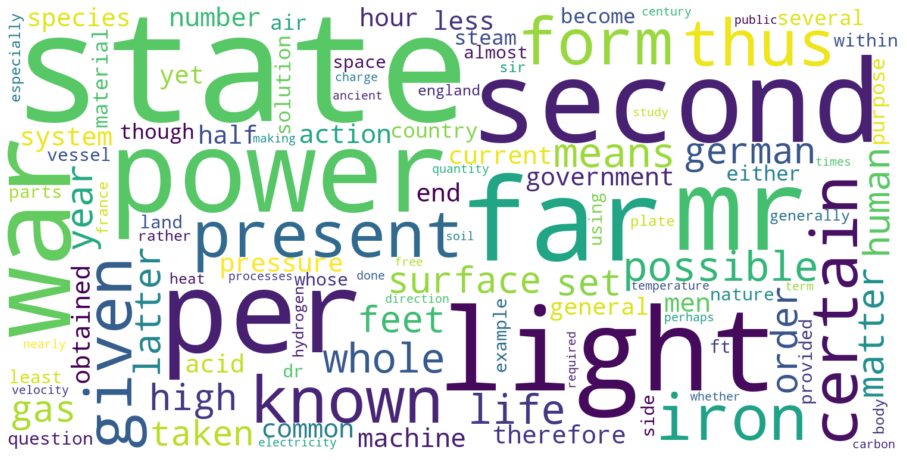

In [8]:
a.word_cloud_top()

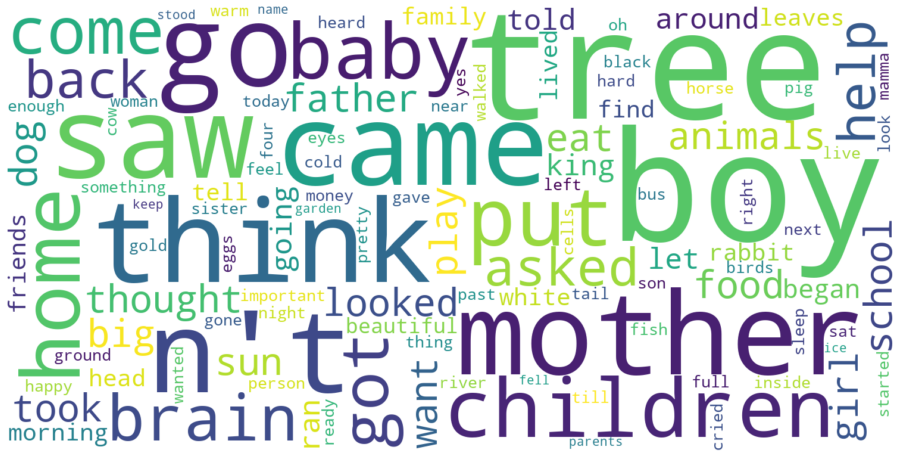

In [9]:
a.word_cloud_bottom()

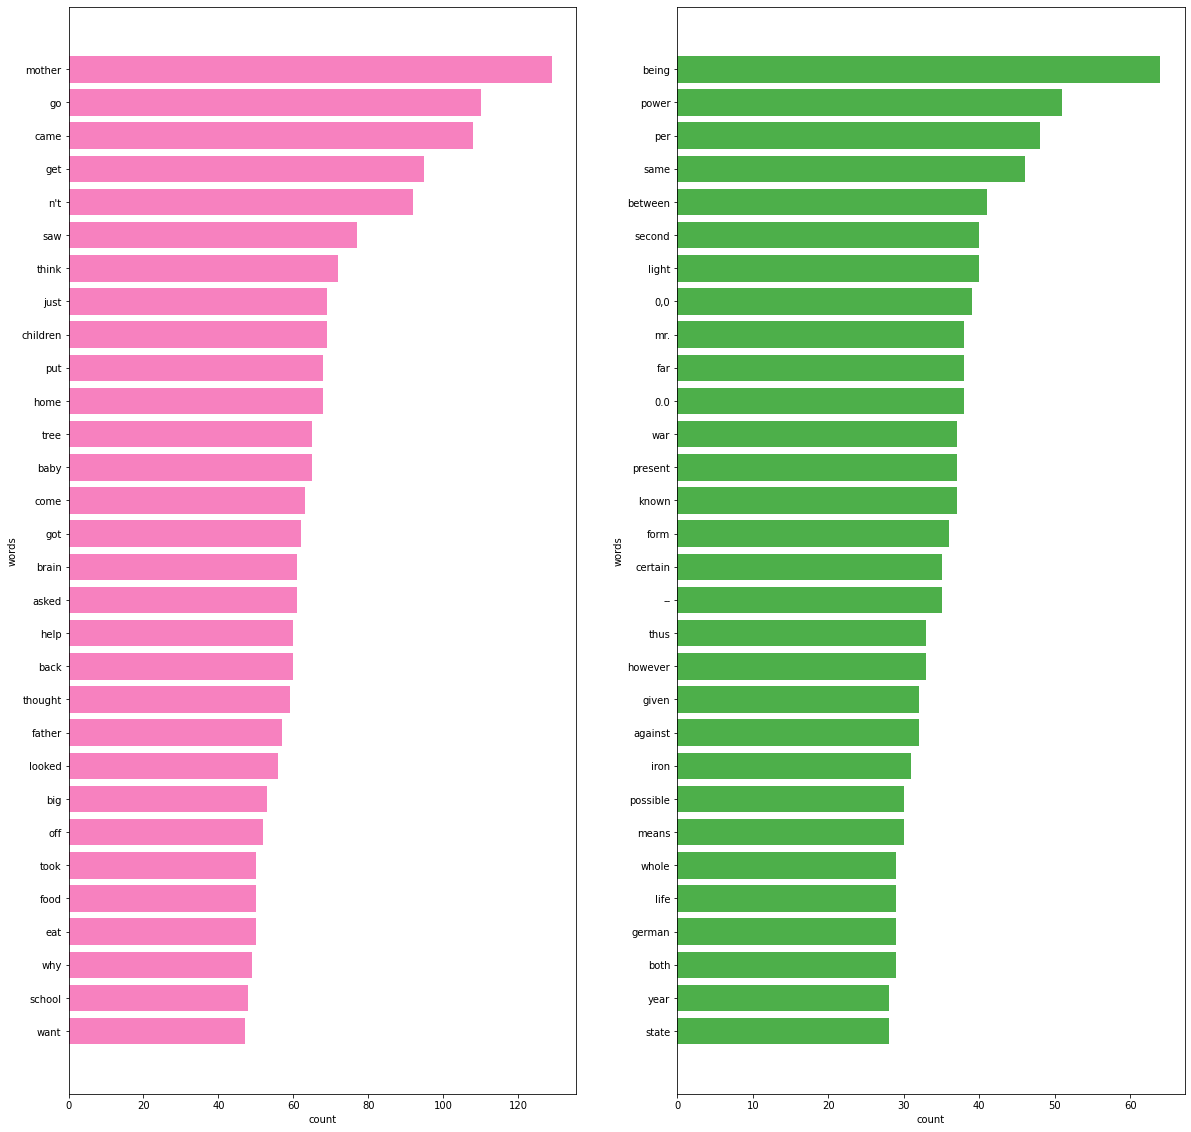

In [10]:
a.words_ranking(word_limit=30)